In [150]:
!pip install torch

import torch
import numpy as np

torch.manual_seed(1);

Mount Google Drive for access to data

In [0]:
import sys
from google.colab import auth
import getpass

if sys.platform == 'linux' and not 'initialized' in locals():
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()

  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  !mkdir -p data
  !google-drive-ocamlfuse data
  
  initialized = True
else:
  print("Already initialized")

Load model if it already exists

In [3]:
import os.path
import pickle
MODEL_FNAME = 'data/models.data'

if os.path.isfile(MODEL_FNAME) and 'load_models' in locals() and load_models:
  with open(MODEL_FNAME, 'rb') as f:
    train_res = pickle.load(f)
else:
  print("Not loading models")

Not loading models


Define global arguments

In [0]:
class args:
  # data set size
  train_size = 10000
  
  # training parameters
  print_every = 40
  plot_every = 80
 
  # sampling
  max_length = 255

Define the alphabet dictionary

In [0]:
from collections import defaultdict

# Define alphabet dictionary
next_index = 0
def get_new_index():
  global next_index
  index = next_index
  next_index += 1
  return index

alphabet = defaultdict(get_new_index)

# Data preprocessing

Load the phishing domains from a file. The file is expected to contain a pickled Python list of strings. Example:
```
first.domain.com
second.domain.com
third.domain.com
last.domain.com
```

In [0]:
import pickle

TRAIN_FILE = "data/phishing_domains.dat"
with open(TRAIN_FILE, 'rb') as f:
    data = pickle.load(f)  

Tokenize data and fill (reverse) alphabet

In [0]:
import itertools
import numpy as np

np.random.seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def tokenize(data):
  # Returns a list of Tensors, with each integer in the tensor representing a character in a domain name.
  # Note that domain names are case-insensitive.
  return [torch.tensor([alphabet['<s>']] + [alphabet[i] for i in domain.lower()] + [alphabet['</s>']]).to(device) for domain in data]

def detokenize(t):
  # Recreate domain name from tensor 1d t
  res = ''
  for token in t:
    res += reverse_alphabet[token.item()]
  return res

train_domains = data[:args.train_size]
train_tokens = tokenize(train_domains)
  
alphabet_size = len(alphabet)
reverse_alphabet = dict([(v,k) for k, v in alphabet.items()])

np.random.shuffle(train_tokens)

Some helper functions for encoding domains and characters and rand

In [0]:
def one_hot(d):
  # One-hot encoding of 1-d tensor d
  res = torch.zeros(len(d), 1, alphabet_size).to(device)
  for i, char in enumerate(d):
    res[i][0][int(char.item())] = 1
  return res

def encode_inputs(d):
  # One-hot encoding for the input of a 1d tensor
  return one_hot(d[:-1])

def encode_targets(d):
  # Return targets for 1d tensor d
  return d[1:]

# Training the model

Define model

In [0]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(RNNModel, self).__init__()              
        self.n_hidden = n_hidden

        self.i2h = nn.Linear(n_input + n_hidden, n_hidden)
        self.i2o = nn.Linear(n_input + n_hidden, n_output)
        self.o2o = nn.Linear(n_hidden + n_output, n_output)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden=None):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
      return torch.zeros(1, self.n_hidden).to(device)
    
lossfn = nn.NLLLoss()

Define train function, which trains a model on a single domain name

In [0]:
from torch.nn.utils import clip_grad_norm_

def train_example(model, optimizer, sample):
  # train on a single example domain name
  inputs, targets = encode_inputs(sample), encode_targets(sample)

  hidden = model.init_hidden()
  targets.unsqueeze_(-1)
 
  loss = 0
    
  for i in range(inputs.size(0)):    
    input, target = inputs[i], targets[i]
    output, hidden = model(input, hidden)
    loss += lossfn(output, target)   

  optimizer.zero_grad()
  loss.backward()
  clip_grad_norm_(model.parameters(), 5) # clip gradients to prevent explosion of loss
  optimizer.step()
    
  return output, loss.item()/inputs.size(0)   

Util function for timing

In [0]:
import time
import math

def elapsed(since):
  # Return a string representing the elapsed time since 'since'
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def now():
  return time.time()

Train the model. The training function iterates over de training set and trains per domain name. The loss of all character predictions in the domain name is backpropagated.

In [0]:
def train(model, optimizer):
  print_loss, plot_loss, all_losses = 0, 0, []  
  start = now()

  for i, sample in enumerate(train_tokens):
    output, loss = train_example(model, optimizer, sample)
    print_loss += loss
    plot_loss += loss

    if (i+1) % args.print_every == 0:    
      avg_loss = print_loss / args.print_every
      print("%s (%d %.2f%%) %.4f" % (elapsed(start), i+1, (i+1)/args.train_size*100, avg_loss))
      print_loss = 0

    if (i+1) % args.plot_every == 0:
      avg_loss = plot_loss / args.plot_every
      all_losses.append(avg_loss)
      plot_loss = 0
      
  return all_losses

train_res = []

n_hidden = [128]
learning_rates = [1e-3]
for n in n_hidden:
  for lr in learning_rates:
    print("Training with %d hidden nodes and a learning rate of %f" % (n, lr))
    model = RNNModel(alphabet_size, n, alphabet_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model_losses = train(model, optimizer)

    train_res.append((model, n, lr, model_losses))
   

In [0]:
if 'save_models' in locals() and save_models:
  with open(MODEL_FNAME, 'wb') as f:
    pickle.dump(train_res, f)
else:
  print("Model saving disabled. Use 'save_models = True' to enable model saving")

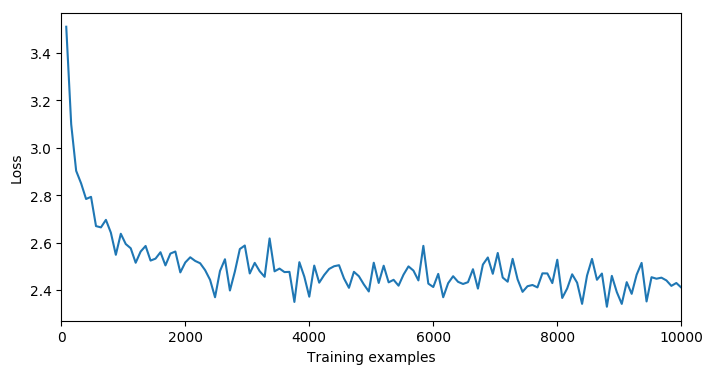

In [168]:
import matplotlib.pyplot as plt

mpl.style.use('default')
plt.figure()
X = np.arange(0, (args.train_size // args.plot_every)*args.plot_every, args.plot_every)+args.plot_every
for model, n, lr, model_losses in train_res:
  line, = plt.plot(X, model_losses[:len(X)+1])
  line.set_label("%d hidden nodes, %.4f learning rate" % (n, lr))
plt.xlim(0, args.train_size)
plt.xlabel("Training examples")
plt.ylabel("Loss")
fig = plt.gcf()
fig.set_size_inches(8, 4)

plt.savefig('learning_curve.eps')

# Domain name generation

Sample the network to generate domain names

In [149]:
from collections import OrderedDict
import sklearn
from tqdm import tqdm

def one_hot_letter(l):
  # One-hot encoding of letter
  return one_hot(torch.tensor([alphabet[l]]))[0]

def sample(model, start_letter='<s>'):
  model.eval()
  with torch.no_grad():
    input = one_hot_letter(start_letter)
    hidden = model.init_hidden()   

    res = '' if start_letter == '<s>' else start_letter
    
    for i in range(args.max_length):   
      output, hidden = model(input, hidden)
      p = output.exp()[0]
      predicted_num = torch.multinomial(p, 1).item()
      if predicted_num == alphabet['</s>']:
        # model generated an 'end-of-sequence'
        break
      predicted_letter = reverse_alphabet[predicted_num]
      res += predicted_letter
      input = one_hot_letter(predicted_letter)    
      
    return res

def p_startchar(dataset, alphabet):
  # returns the probabilities of a domain name starting with a parcticular character, based on the given dataset
  res = OrderedDict()
  for a in alphabet:
    res[a] = sum([domain.startswith(a) for domain in dataset])
  res = np.array(list(res.values()))
  return res/res.sum()
  
# generate 10000 domain names
generated_domains = []
for i in tqdm(range(10000)):
  generated_domains.append(sample(train_res[0][0]))

100%|██████████| 10000/10000 [04:45<00:00, 34.98it/s]


In [0]:
train_parts = [tldextract.extract(domain) for domain in train_domains]
generated_parts = [tldextract.extract(domain) for domain in generated_domains]

In [207]:
def num_labels(s):
  """
  Returns the number of labels in the provided string
  """
  if s == "":
    return 0
  return len(s.split("."))

print("-- Stats domains")
print("Length domain")
print("Training")
print("\tMean: %f" % np.mean([len(d) for d in train_domains]))
print("\tStdev: %f" % np.std([len(d) for d in train_domains]))
print("Generated")
print("\tMean: %f" % np.mean([len(d) for d in generated_domains]))
print("\tStdev: %f" % np.std([len(d) for d in generated_domains]))

print("# labels")
print("Training")
print("\tMean: %f" % np.mean([num_labels(d) for d in train_domains]))
print("\tStdev: %f" % np.std([num_labels(d) for d in train_domains]))
print("Generated")
print("\tMean: %f" % np.mean([num_labels(d) for d in generated_domains]))
print("\tStdev: %f" % np.std([num_labels(d) for d in generated_domains]))

print("Valid TLDs")
print("Training")
print("\t%%: %f" % (sum([d.suffix != '' for d in train_parts])/len(train_parts)))
print("Generated")
print("\t%%: %f" % (sum([d.suffix != '' for d in generated_parts])/len(generated_parts)))

-- Stats domains
Length domain
Training
	Mean: 26.002700
	Stdev: 20.483293
Generated
	Mean: 24.733900
	Stdev: 16.328365
# labels
Training
	Mean: 3.394400
	Stdev: 2.196781
Generated
	Mean: 3.263700
	Stdev: 1.643095
Valid TLDs
Training
	%: 0.952300
Generated
	%: 0.579800
